In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import glob

/usr/local/other/anaconda/GEOSpyD/24.3.0-0/2024-08-29/envs/py3.12/envs/viz/lib/python3.11/site-packages/pydap/lib.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [2]:
files = sorted(glob.glob("./data_rank*.nc"))
ds = [xr.open_dataset(f) for f in files]
num_ranks = len(ds)

In [3]:
ds[0]

<xarray.Dataset>
Dimensions:        (num_nodes: 582, num_elements: 968, num_owned_nodes: 582)
Dimensions without coordinates: num_nodes, num_elements, num_owned_nodes
Data variables:
    node_lon       (num_nodes) float32 ...
    node_lat       (num_nodes) float32 ...
    node_ids       (num_nodes) float32 ...
    node_owners    (num_nodes) float32 ...
    element_lon    (num_elements) float32 ...
    element_lat    (num_elements) float32 ...
    element_ids    (num_elements) float32 ...
    element_conn1  (num_elements) float32 ...
    element_conn2  (num_elements) float32 ...
    element_conn3  (num_elements) float32 ...
    node_surf      (num_owned_nodes) float32 ...
    element_surf   (num_elements) float32 ...

In [4]:
triang = {}
triang_masked = {}
for rank in range(num_ranks):
    # mesh element node indices
    lon = ds[rank]["node_lon"].values
    lat = ds[rank]["node_lat"].values
    node_ids = ds[rank]["node_ids"].values.astype('int') - 1
    element_conn1 = ds[rank]["element_conn1"].values.astype('int') - 1
    element_conn2 = ds[rank]["element_conn2"].values.astype('int') - 1
    element_conn3 = ds[rank]["element_conn3"].values.astype('int') - 1
    triangles = np.zeros((element_conn1.size,3))
    triangles[:,0] = element_conn1
    triangles[:,1] = element_conn2
    triangles[:,2] = element_conn3
    triang[rank] = Triangulation(lon,lat,triangles)

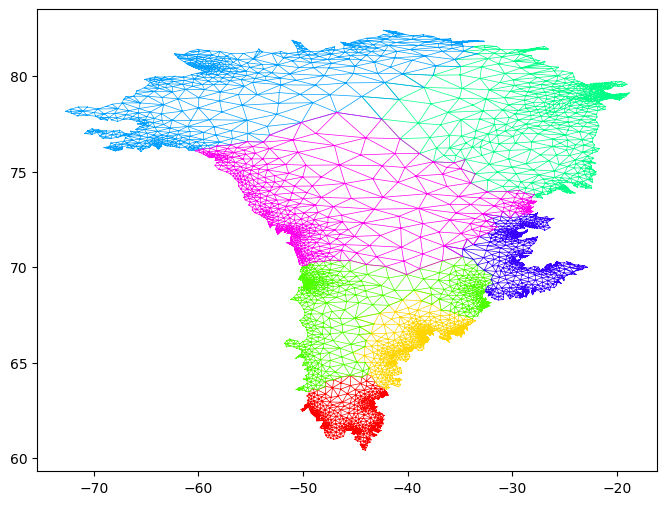

In [5]:
plt.figure(figsize=(8,6))
for rank in range(num_ranks):
    color = plt.cm.hsv(rank / num_ranks)
    plt.triplot(triang[rank],color=color,linewidth=0.5)
plt.show()
plt.close()


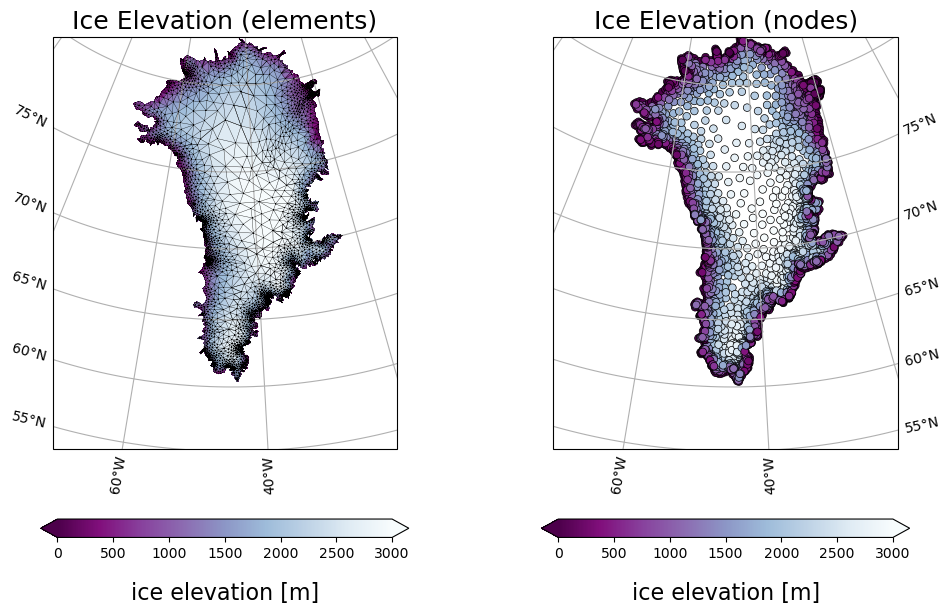

In [6]:
proj = ccrs.LambertConformal(central_longitude=-45, central_latitude=70)

fig, axes = plt.subplots(
    1, 2, figsize=(10, 6),
    subplot_kw={'projection': proj},
    constrained_layout=True
)

extent = [-70, -22, 55, 82]

# ax = plt.axes(projection=proj)

# Set extent around Greenland: [west_lon, east_lon, south_lat, north_lat]
ax = axes[0]
ax.set_extent(extent, crs=ccrs.PlateCarree())
# ax.set_extent([-45, -39, 71.5, 73.5], crs=ccrs.PlateCarree())


# Add gridlines
gl = ax.gridlines(draw_labels=True, 
                  dms=True, 
                  x_inline=False, 
                  y_inline=False)
gl.top_labels = False
gl.right_labels = False
for rank in range(num_ranks):
    with np.errstate(invalid='ignore'):
        ax.triplot(triang[rank],color='k',linewidth=0.25,transform=ccrs.PlateCarree(),zorder=100)
        p1 = ax.tripcolor(triang[rank],ds[rank]["element_surf"].values,cmap='BuPu_r',vmin=0,vmax=3000,transform=ccrs.PlateCarree())
cbar = plt.colorbar(p1,extend='both',orientation='horizontal',shrink=0.75)
cbar.set_label(r'ice elevation [m]',fontsize=16,labelpad=15)
ax.set_title("Greenland Ice Elevation (mesh)",fontsize=18)
cbar.set_label(r'ice elevation [m]',fontsize=16,labelpad=15)
ax.set_title("Ice Elevation (elements)",fontsize=18)

ax = axes[1]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Use FixedLocator with the actual grid points
gl = ax.gridlines(draw_labels=True, 
                  dms=True, 
                  x_inline=False, 
                  y_inline=False)
gl.top_labels = False
gl.left_labels = False
gl.right_labels = True

for rank in range(num_ranks):
    lon = ds[rank]["node_lon"].values
    lat = ds[rank]["node_lat"].values
    elevation_nodes = ds[rank]["node_surf"].values
    node_owners = ds[rank]["node_owners"].values.astype('int')
    with np.errstate(invalid='ignore'):
        p2 = ax.scatter(lon[node_owners==rank],lat[node_owners==rank],c=elevation_nodes,s=30,edgecolors='k',linewidths=0.5,cmap='BuPu_r',vmin=0,vmax=3000,transform=ccrs.PlateCarree())
cbar = plt.colorbar(p2,extend='both',orientation='horizontal',shrink=0.75)
cbar.set_label(r'ice elevation [m]',fontsize=16,labelpad=15)
ax.set_title("Ice Elevation (nodes)",fontsize=18)
plt.show()
plt.close()